In [195]:
import numpy as np
import cv2
import time
import os
import random

import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Подготовка

In [ ]:
#ffmpeg -ss 00:00:02 -i "mam.MOV" -f image2 -vframes 1 "file_out.jpg"

In [189]:
# функции нарезки фото из видео
# функция нарезает каждый фрэйм
# разворачивает и уменьшает картинку

def video_to_frames(video, prefix):
    # extract frames from a video and save to directory as 'x.jpg' where 
    # x is the frame index
    #video = cv2.VideoCapture('/Users/alexeyvaganov/doc/files/foto_mp/pap.mov')
    vidcap = cv2.VideoCapture(video)
    count = 0
    while vidcap.isOpened():
        success, image = vidcap.read()
        if success:
           # img_name = os.path.join(path_output_dir, 'img_%s_%d_0.jpg') % (prefix,count)
            img_name = 'img_%s_%d.jpg' % (prefix,count)
            img_path = return_file_name(img_name)
            cv2.imwrite(img_path,image) 
            convert_image(img_path)
            #augmentation(img_name)
            count += 1
        else:
            break
    # print(count)
    cv2.destroyAllWindows()
    vidcap.release()

def convert_image(image_path): # конвертировать картинку
    
    image = cv2.imread(image_path)
    
    #scale_percent = 12# Процент от изначального размера
    #width = int(image.shape[1] * scale_percent / 100)
    #height = int(image.shape[0] * scale_percent / 100)
    
    # УКАЗАТЬ РАЗМЕР
    width = 230
    height = 129
    # УКАЗАТЬ РАЗМЕР
    
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    
    # и тут же перевренем
    image = rotate_bound(image, 90)

    cv2.imwrite(image_path, image)
    
def rotate_bound(image, angle): # Повернуть картинку. параметры: картинка, угол
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image

    return cv2.warpAffine(image, M, (nW, nH))    

In [190]:
# функции аугментацию
def augmentation(img_name):
    
    img_name_ws = img_name.replace(".jpg","_")
    
    img = cv2.imread(return_file_name(img_name))
    
    img_aug = rotation(img,30)
    cv2.imwrite(return_file_name(img_name_ws + "r+.jpg"),img_aug)
    
    img_aug = rotation(img,-30)
    cv2.imwrite(return_file_name(img_name_ws + "r-.jpg"),img_aug)
    
    img_aug = vertical_flip(img, True)
    cv2.imwrite(return_file_name(img_name_ws + "v.jpg"),img_aug)
    
    img_aug = horizontal_flip(img, True)
    cv2.imwrite(return_file_name(img_name_ws + "t.jpg"),img_aug)
    
    img_aug = channel_shift(img, 50)
    cv2.imwrite(return_file_name(img_name_ws + "c.jpg"),img_aug)
    
    img_aug = zoom(img, 0.2)
    cv2.imwrite(return_file_name(img_name_ws + "z2.jpg"),img_aug)
    
    img_aug = zoom(img, 0.3)
    cv2.imwrite(return_file_name(img_name_ws + "z3.jpg"),img_aug)
    
    img_aug = brightness(img, 0.5, 3)
    cv2.imwrite(return_file_name(img_name_ws + "b.jpg"),img_aug)
    
    img_aug = vertical_shift(img, 0.7)
    cv2.imwrite(return_file_name(img_name_ws + "vs.jpg"),img_aug)
    
    img_aug = horizontal_shift(img, ratio=0.7)
    cv2.imwrite(return_file_name(img_name_ws + "gs.jpg"),img_aug)     

In [191]:
# вспомогательные функции для аугментации
# https://towardsdatascience.com/complete-image-augmentation-in-opencv-31a6b02694f5

# горизонтальное смещение
def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    img = fill(img, w, h)
    return img

# вертикальное смещение
def vertical_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = h*ratio
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
    img = fill(img, w, h)
    return img

# яркость
def brightness(img, low, high):
    value = random.uniform(low, high)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hsv = np.array(hsv, dtype = np.float64)
    hsv[:,:,1] = hsv[:,:,1]*value
    hsv[:,:,1][hsv[:,:,1]>255]  = 255
    hsv[:,:,2] = hsv[:,:,2]*value 
    hsv[:,:,2][hsv[:,:,2]>255]  = 255
    hsv = np.array(hsv, dtype = np.uint8)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return img

# вспомогательная
def fill(img, h, w):
    img = cv2.resize(img, (h, w), cv2.INTER_CUBIC)
    return img

# зумиррование
def zoom(img, value):
    if value > 1 or value < 0:
        print('Value for zoom should be less than 1 and greater than 0')
        return img
    value = random.uniform(value, 1)
    h, w = img.shape[:2]
    h_taken = int(value*h)
    w_taken = int(value*w)
    h_start = random.randint(0, h-h_taken)
    w_start = random.randint(0, w-w_taken)
    img = img[h_start:h_start+h_taken, w_start:w_start+w_taken, :]
    img = fill(img, w, h)
    return img

# смещение канала
def channel_shift(img, value):
    value = int(random.uniform(-value, value))
    img = img + value
    img[:,:,:][img[:,:,:]>255]  = 255
    img[:,:,:][img[:,:,:]<0]  = 0
    img = img.astype(np.uint8)
    return img

# горизонтальное отображение
def horizontal_flip(img, flag):
    if flag:
        return cv2.flip(img, 1)
    else:
        return img

# вертикальное отображение
def vertical_flip(img, flag):
    if flag:
        return cv2.flip(img, 0)
    else:
        return img

#  сдвиг
def rotation(img, angle):
    angle = int(random.uniform(-angle, angle))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((int(w/2), int(h/2)), angle, 1)
    img = cv2.warpAffine(img, M, (w, h))
    return img

In [192]:
# вспомогательные
def return_file_name(img_name):
    return os.path.join(W_DIR, img_name)

In [193]:
W_DIR = "/Users/alexeyvaganov/doc/files/foto_mp/mam/"
File_Name = "mam.mov"
prefix = "mam"

video_to_frames(os.path.join(W_DIR, File_Name),prefix)


In [194]:
W_DIR = "/Users/alexeyvaganov/doc/files/foto_mp/pap/"
File_Name = "pap.mov"
prefix = "pap"

video_to_frames(os.path.join(W_DIR, File_Name),prefix)

# Обучение

In [196]:
#https://www.tensorflow.org/tutorials/images/transfer_learning
    
PATH = "/Users/alexeyvaganov/doc/files/foto_mp"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2402 files belonging to 2 classes.
Found 1294 files belonging to 2 classes.


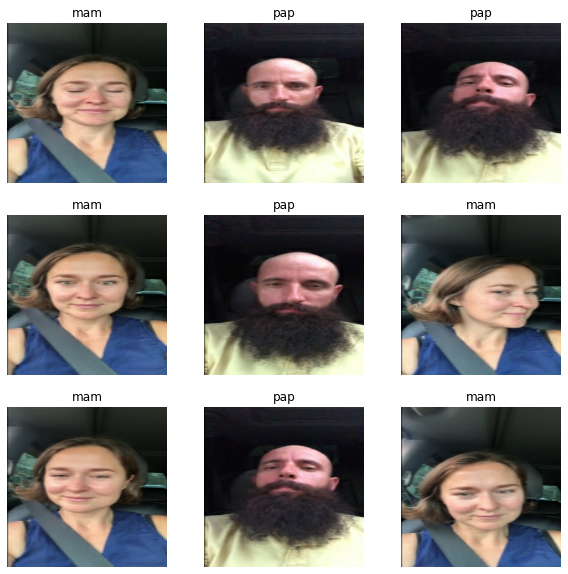

In [197]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [198]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 33
Number of test batches: 8


In [200]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

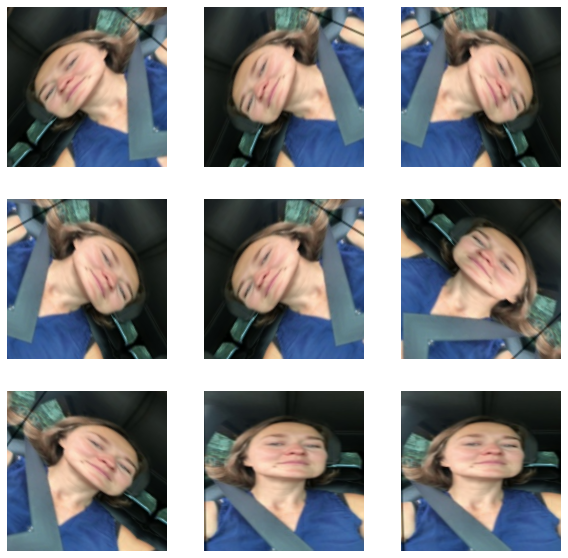

In [201]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [202]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [203]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

(32, 5, 5, 1280)
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
______________________________________________________________

In [204]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [205]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [206]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [207]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [208]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [212]:
initial_epochs = 3

loss0, accuracy0 = model.evaluate(validation_dataset)

33/33 [==============================] - 16s 467ms/step - loss: 0.0219 - accuracy: 1.0000


In [214]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.02
initial accuracy: 1.00


In [215]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/3
76/76 [==============================] - 57s 751ms/step - loss: 0.0225 - accuracy: 0.9996 - val_loss: 0.0190 - val_accuracy: 1.0000
Epoch 2/3
76/76 [==============================] - 65s 859ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 0.0160 - val_accuracy: 1.0000
Epoch 3/3
76/76 [==============================] - 67s 880ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.0147 - val_accuracy: 1.0000


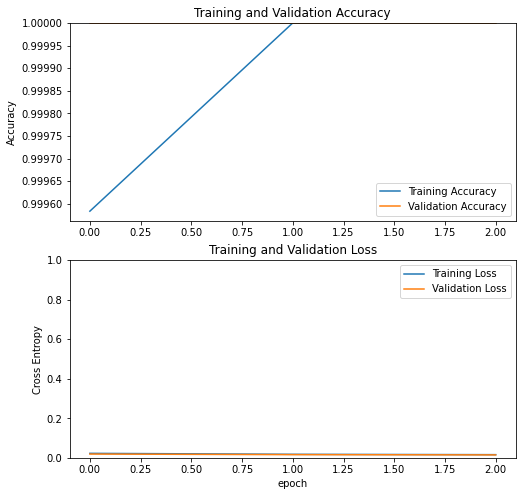

In [216]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1]
Labels:
 [0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 1]


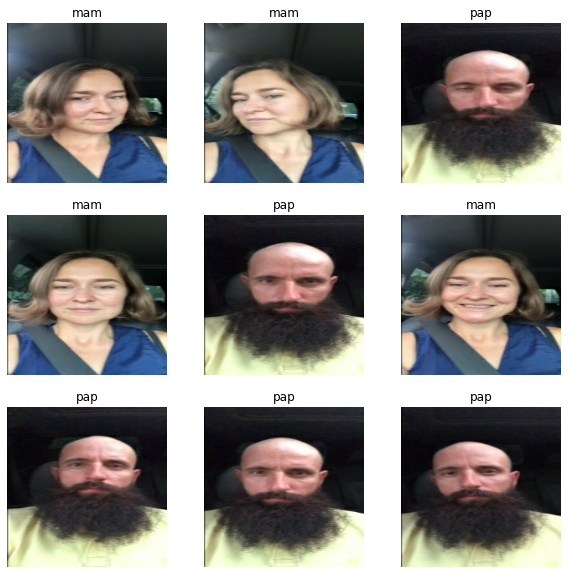

In [217]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [236]:
image = tf.keras.preprocessing.image.load_img("/Users/alexeyvaganov/doc/files/predication/8280c50b122d19dcdbd935de788f499a.jpg",grayscale=False, color_mode="rgb", target_size=IMG_SIZE)
input_arr = keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions_ = model.predict(input_arr)

predictions = tf.nn.sigmoid(predictions_)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions)
print(class_names[predictions.numpy()[0][0]])
print(predictions_)

Predictions:
 tf.Tensor([[0]], shape=(1, 1), dtype=int32)
mam
[[-0.6291802]]
